<a href="https://colab.research.google.com/github/Molten-Ice/3dGolfPoseDetection/blob/colab/dev-nbs/9-training-on-1k-images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Apr 24 20:58:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    42W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from torchvision.models.detection import keypointrcnn_resnet50_fpn, KeypointRCNN_ResNet50_FPN_Weights
# import albumentations as A # Library for augmentations
import os
import cv2
import json
import time
import random
import argparse
import numpy as np
from PIL import Image, ImageOps
from pathlib import Path
import matplotlib.pyplot as plt

# repo_dir = "c:/Users/James/git/3dGolfPoseDetection/"
# repo_dir = "/home/fsuser/3dGolfPoseDetection/"
repo_dir = "/content/"
data_path = repo_dir + "downloaded-data/"

if not os.path.exists(data_path): 
    print("Creating folder: ", data_path)
    os.mkdir(data_path)

In [2]:
### Download data from kaggle on google colab) ###

import json
import zipfile
kaggle_apikey = {"username":"jamesdavey","key":"a8975caa44cfa08d6f2164f2d5977b6e"}

if not os.path.exists('/root/.kaggle'): os.mkdir('/root/.kaggle')
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_apikey, f)

! chmod 600 ~/.kaggle/kaggle.json

!kaggle config set -n path -v {data_path}

## Download and unzip data ##

! kaggle datasets download jamesdavey/labelled-golf-clubs
zip_path = data_path+"datasets/jamesdavey/labelled-golf-clubs/labelled-golf-clubs.zip"
with zipfile.ZipFile(zip_path,"r") as zip_ref:
    zip_ref.extractall(data_path)

- path is now set to: /content/downloaded-data/
labelled-golf-clubs.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
def label_img(img, grip, club, box_cords, line_width=4):
    cv2.circle(img, grip[:2], 6, (255,0,255), -1)
    cv2.circle(img, club[:2], 6, (255,0,255), -1)
    cv2.line(img, club[:2], grip[:2], (255, 0, 0), 2)
    cv2.rectangle(img, box_cords[:2], box_cords[2:], (0, 0, 255), line_width)
    return img

class GolfDataset(torch.utils.data.Dataset):
    def __init__(self, save_dir, filenames, device = "cpu", annotate = False, padding = False):
        self.save_dir = save_dir
        self.filenames = filenames
        self.annotate = annotate
        self.img_transforms = transforms.ToTensor()
        self.padding = padding

    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        filename = self.filenames[idx]
        img = cv2.imread(self.save_dir+filename)
        cords = [int(x) for x in filename.split("_")[1].split("-")]
        grip, club = cords[:2], cords[2:]
        box_buffer = max(img.shape[:2])//20
        box_cords = [
            max(min(grip[0], club[0])-box_buffer, 1),
            max(min(grip[1], club[1])-box_buffer, 1), #top left cord
            min(max(grip[0], club[0])+box_buffer, img.shape[1]-1), # shape[0] is y
            min(max(grip[1], club[1])+box_buffer, img.shape[0]-1)] # bottom right cord
        
        if self.annotate:
            img = label_img(img, grip, club, box_cords)
        
        if self.padding:
            max_height, max_width = 720, 1225
            height, width = img.shape[:2]
            img = cv2.copyMakeBorder(img, 0, max_height-height, 0, max_width-width, cv2.BORDER_CONSTANT)

        # During training, the model expects both the input tensors and targets (list of dictionary), containing:
        # boxes (FloatTensor[N, 4]): the ground-truth boxes in [x1, y1, x2, y2] format, with 0 <= x1 < x2 <= W and 0 <= y1 < y2 <= H.
        # labels (Int64Tensor[N]): the class label for each ground-truth box
        # keypoints (FloatTensor[N, K, 3]): the K keypoints location for each of the N instances, in the format [x, y, visibility], where visibility=0 means that the keypoint is not visible.
        
        grip.append(1.)
        club.append(1.)
        target = {}
        target["boxes"] = torch.Tensor(box_cords).unsqueeze(dim=0).type(torch.FloatTensor)
        target["labels"] = torch.Tensor(torch.ones(1)).type(torch.int64)
        target["keypoints"] = torch.Tensor([grip, club]).unsqueeze(dim=0).type(torch.FloatTensor)

        img = Image.fromarray(img[:, :, ::-1])
        img = self.img_transforms(img)

        return img, target
    
def collate_fn(batch):
    return tuple(zip(*batch))

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model = keypointrcnn_resnet50_fpn(weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT)
model.eval()
out = nn.ConvTranspose2d(512, 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
model.roi_heads.keypoint_predictor.kps_score_lowres = out
model = model.to(device)

#freeze parameters in backbone
for param in model.backbone.parameters():
    param.requires_grad = False

In [7]:
batch_size = 8

images_dir = data_path + "saved-labels/"
filenames = sorted(os.listdir(images_dir))

train_test_split = 0.8
split_index = int(len(filenames)*train_test_split)
train_filenames, test_filenames = filenames[:split_index], filenames[split_index:]

train_dataset = GolfDataset(images_dir, train_filenames, device = device, annotate = False, padding = False)
train_dataloader = torch.utils.data.DataLoader(train_dataset, collate_fn=collate_fn, batch_size=batch_size, shuffle=False)

test_dataset = GolfDataset(images_dir, test_filenames, device = device, annotate = False, padding = False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, collate_fn=collate_fn, batch_size=batch_size, shuffle=False)

print(f"Dataset lengths | train {len(train_dataset)}, test {len(test_dataset)}")
print(f"Dataloader #batches | train {len(train_dataloader)}, test {len(test_dataloader)}, batches of size {batch_size}")

# batch = next(iter(train_dataloader))
# display_img = Image.fromarray((torchvision.utils.make_grid(torch.stack(batch[0],dim=0).cpu(), nrow = 3).permute(1,2,0).numpy()*255).astype(np.uint8))
# display(ImageOps.contain(display_img, (1000, 1000)))


Dataset lengths | train 800, test 200
Dataloader #batches | train 100, test 25, batches of size 8


In [8]:
def evaluate_model(model, dataloader):
    box_diffs = []
    keypoint_diffs = []
    total_elements = 0

    t_start = time.time()
    model.eval()
    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            images = [img.to(device) for img in batch[0]]
            targets = [{key: d[key].to(device) for key in d.keys()} for d in batch[1]]
            preds = model(images)

            total_elements+=len(preds)
            for idx in range(len(preds)):
                predicted_boxes = preds[idx]['boxes']
                predicted_clubs = preds[idx]['keypoints']
                if len(predicted_boxes) > 0:
                    real_box = targets[idx]['boxes'][0]
                    box_diffs.append(torch.abs(predicted_boxes[0] - real_box))

                if len(predicted_clubs) > 0:
                    real_keypoints = targets[idx]['keypoints'][0]
                    keypoint_diffs.append(torch.abs(predicted_clubs[0] - real_keypoints)[:,:2])
    model.train()

    if len(box_diffs) == 0:
        average_box_diff = ['inf', 'inf', 'inf', 'inf']
        boxes_predicted = 0
    else:
        stacked_boxes = torch.stack(box_diffs,dim=0).cpu().numpy()
        average_box_diff = np.mean(stacked_boxes, axis=0)
        boxes_predicted = stacked_boxes.shape[0]

    if len(keypoint_diffs) == 0:
        average_club_diff = ['inf', 'inf', 'inf']
        keypoints_predicted = 0
    else:
        stacked_keypoints = torch.stack(keypoint_diffs,dim=0).cpu().numpy() #[[(x_grip, y_grip), (x_club, y_club)],...]
        average_keypoint_diff = np.mean(stacked_keypoints, axis=0)
        keypoints_predicted = stacked_keypoints.shape[0]

    return average_box_diff, average_keypoint_diff, total_elements, boxes_predicted, keypoints_predicted, time.time()-t_start

In [ ]:
# Use data Augmentation!!!
# Train Evaluation | bbox: 142.68, grip: 73.04, head: 186.31 | bbox: [800/800], keypoints: [800/800], Time taken: 41.49s
# Test Evaluation | bbox: 143.12, grip: 78.81, head: 188.26 | bbox: [200/200], keypoints: [200/200], Time taken: 10.10s
# ↓↓↓
# Train Evaluation | bbox: 8.06, grip: 1.66, head: 3.97 | bbox: [800/800], keypoints: [800/800], Time taken: 39.32s
# Test Evaluation | bbox: 20.59, grip: 6.08, head: 26.63 | bbox: [200/200], keypoints: [200/200], Time taken: 10.04s


In [9]:
train_keypoints = True

keys_to_train = ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']
if train_keypoints:
    keys_to_train.append('loss_keypoint')

### Hyperparameters ###

epochs = 9
lr = 3e-4
eval_interval = 2

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=lr)
lr_scheduler_epochs = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)


metrics = {"Train_boxes": [],
           "Train_keypoints": [],
           "Test_boxes": [],
           "Test_keypoints": []}

# Starting evaluation
for split, dataloader in zip(["Train", "Test"], [train_dataloader, test_dataloader]):
    average_box_diff, average_keypoint_diff, total_elements, boxes_predicted, clubs_predicted, time_taken = evaluate_model(model, dataloader)
    print(f"{split} Evaluation | bbox: {average_box_diff.mean():.2f}, grip: {average_keypoint_diff[0].mean():.2f}, head: {average_keypoint_diff[1].mean():.2f} | bbox: [{boxes_predicted}/{total_elements}], keypoints: [{clubs_predicted}/{total_elements}], Time taken: {time_taken:.2f}s")
    metrics[f"{split}_boxes"].append(average_box_diff)
    metrics[f"{split}_keypoints"].append(average_keypoint_diff)

### Training loop ###
losses = []
lrs = []

t_start = time.time()
model.train()
for epoch in range(epochs):
    print(f"--------- EPOCH {epoch} ---------")
    if epoch == 0: # learning rate warmup
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(train_dataloader) - 1)
        lr_scheduler_warmup = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=warmup_factor, total_iters=warmup_iters)

    for batch_idx, batch in enumerate(train_dataloader):
        images = [img.to(device) for img in batch[0]]
        targets = [{key: d[key].to(device) for key in d.keys()} for d in batch[1]]

        losses_dict = model(images, targets)
        total_loss = sum([losses_dict[key] for key in keys_to_train])
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if epoch == 0:
            lr_scheduler_warmup.step()
        lrs.append(optimizer.param_groups[0]['lr'])
        losses.append([losses_dict[key].item() for key in keys_to_train])

        if batch_idx % (len(train_dataloader)//3) == 0:
            print(f"Epoch [{epoch+1}/{epochs}], batch [{batch_idx+1}/{len(train_dataloader)}] | Total loss: {total_loss.item():.2f}, Time: {time.time()-t_start:.2f}s | {''.join([f'{key}: {losses_dict[key].item():.4f}, ' for key in keys_to_train])}")

    lr_scheduler_epochs.step()

    if epoch % eval_interval == 0:   
        for split, dataloader in zip(["Train", "Test"], [train_dataloader, test_dataloader]):
            average_box_diff, average_keypoint_diff, total_elements, boxes_predicted, clubs_predicted, time_taken = evaluate_model(model, dataloader)
            print(f"{split} Evaluation | bbox: {average_box_diff.mean():.2f}, grip: {average_keypoint_diff[0].mean():.2f}, head: {average_keypoint_diff[1].mean():.2f} | bbox: [{boxes_predicted}/{total_elements}], keypoints: [{clubs_predicted}/{total_elements}], Time taken: {time_taken:.2f}s")
            metrics[f"{split}_boxes"].append(average_box_diff)
            metrics[f"{split}_keypoints"].append(average_keypoint_diff)


Train Evaluation | bbox: 142.68, grip: 73.04, head: 186.31 | bbox: [800/800], keypoints: [800/800], Time taken: 41.49s
Test Evaluation | bbox: 143.12, grip: 78.81, head: 188.26 | bbox: [200/200], keypoints: [200/200], Time taken: 10.10s
--------- EPOCH 0 ---------
Epoch [1/9], batch [1/100] | Total loss: 10.16, Time: 1.06s | loss_classifier: 0.2439, loss_box_reg: 0.0886, loss_objectness: 0.1235, loss_rpn_box_reg: 0.0041, loss_keypoint: 9.7027, 
Epoch [1/9], batch [34/100] | Total loss: 4.62, Time: 15.79s | loss_classifier: 0.0689, loss_box_reg: 0.0948, loss_objectness: 0.0266, loss_rpn_box_reg: 0.0062, loss_keypoint: 4.4220, 
Epoch [1/9], batch [67/100] | Total loss: 3.86, Time: 30.29s | loss_classifier: 0.0824, loss_box_reg: 0.1166, loss_objectness: 0.0154, loss_rpn_box_reg: 0.0043, loss_keypoint: 3.6396, 
Epoch [1/9], batch [100/100] | Total loss: 3.89, Time: 45.01s | loss_classifier: 0.0678, loss_box_reg: 0.1077, loss_objectness: 0.0186, loss_rpn_box_reg: 0.0050, loss_keypoint: 3.69

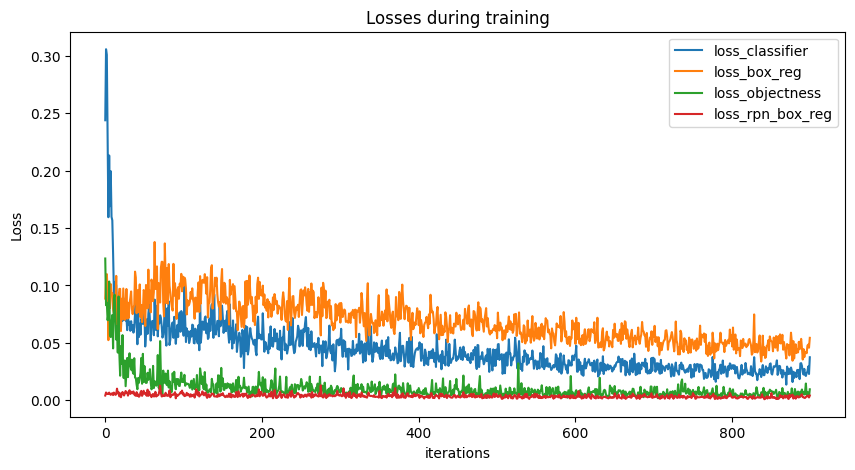

In [10]:
plt.figure(figsize=(10,5))
plt.title("Losses during training")
losses = np.array(losses)
for i, key in enumerate(keys_to_train[:4]):
    plt.plot(losses[:,i],label=key)

plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

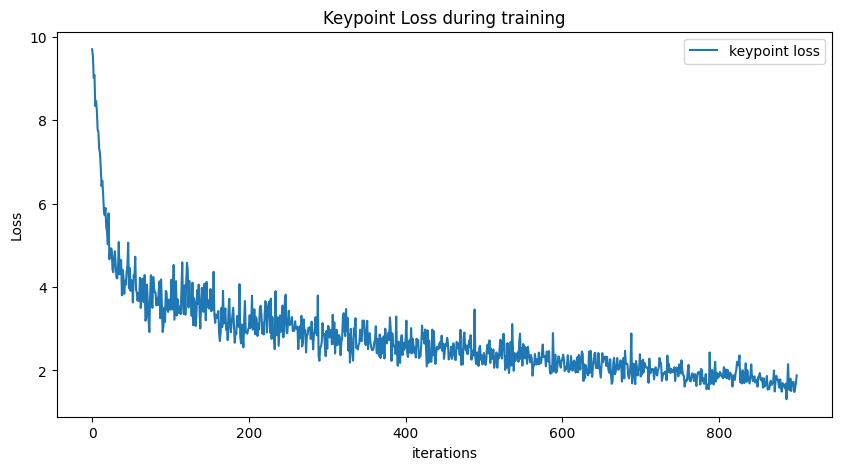

In [11]:
plt.figure(figsize=(10,5))
plt.title("Keypoint Loss during training")
plt.plot(losses[:,4],label="keypoint loss")

plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

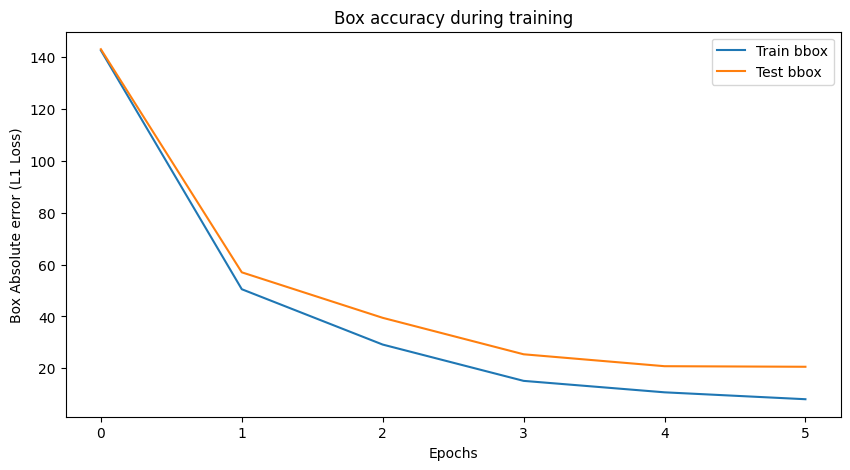

In [12]:
plt.figure(figsize=(10,5))
plt.title("Box accuracy during training")

plt.plot(np.array(metrics['Train_boxes']).mean(axis=1), label = "Train bbox")
plt.plot(np.array(metrics['Test_boxes']).mean(axis=1), label = "Test bbox")

plt.xlabel("Epochs")
plt.ylabel("Box Absolute error (L1 Loss)")
plt.legend()
plt.show()

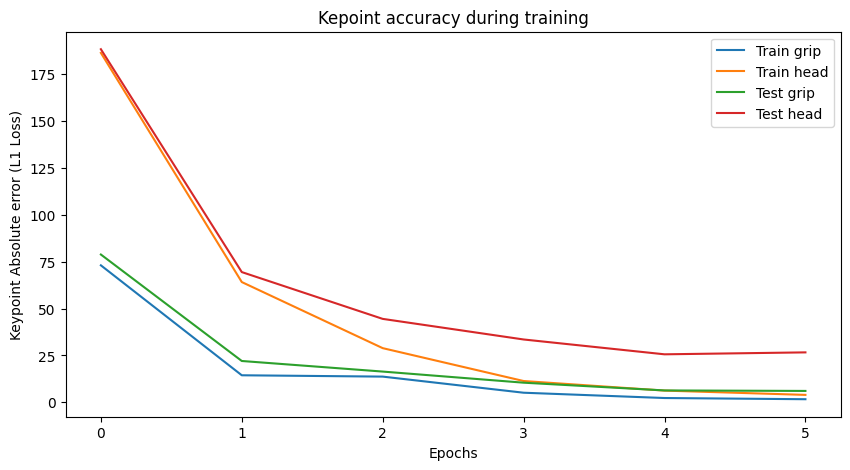

In [13]:
plt.figure(figsize=(10,5))
plt.title("Kepoint accuracy during training")

plt.plot(np.array(metrics['Train_keypoints']).mean(axis=2)[:, 0], label = "Train grip")
plt.plot(np.array(metrics['Train_keypoints']).mean(axis=2)[:, 1], label = "Train head")


plt.plot(np.array(metrics['Test_keypoints']).mean(axis=2)[:, 0], label = "Test grip")
plt.plot(np.array(metrics['Test_keypoints']).mean(axis=2)[:, 1], label = "Test head")

plt.xlabel("Epochs")
plt.ylabel("Keypoint Absolute error (L1 Loss)")
plt.legend()
plt.show()


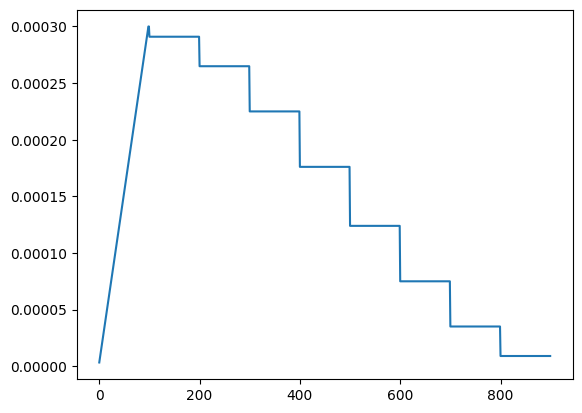

In [14]:
plt.plot(lrs)

In [48]:
def label_pred(tensor_img, box, keypoints):
    
    img = (tensor_img*255).type(torch.uint8).permute(1,2,0).cpu().numpy()


    labelled = img[: , : , ::-1].copy().astype(np.uint8)

    box_cords = [int(x) for x in box]
    cv2.rectangle(labelled, box_cords[:2], box_cords[2:], (124,252,0), 3)

    grip, club = keypoints
    grip = [int(x) for x in grip[:2]]
    club = [int(x) for x in club[:2]]
    cv2.circle(labelled, grip, 5, (200, 0, 0), -1)
    cv2.circle(labelled, club, 5, (200, 0, 0), -1)
    cv2.line(labelled, club[:2], grip[:2], (0, 128, 255), 2)

    max_height, max_width = 720, 1225
    height, width = labelled.shape[:2]
    labelled = cv2.copyMakeBorder(labelled, 0, max_height-height, 0, max_width-width, cv2.BORDER_CONSTANT)

    labelled = labelled[:,:,::-1]
    return labelled.copy()

In [64]:
def generate_predictions(model, dataloader, imgs_to_generate = 16):

    img_transforms = transforms.ToTensor()
    labelled_images = []

    model.eval()
    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            if len(labelled_images) >= imgs_to_generate:
                break

            images = [img.to(device) for img in batch[0]]
            targets = batch[1] # [{key: d[key].to(device) for key in d.keys()} for d in batch[1]]
            preds = model(images)

            for idx in range(len(preds)):
                predicted_boxes = preds[idx]['boxes']
                predicted_clubs = preds[idx]['keypoints']

                if not (len(predicted_boxes > 0) and len(predicted_clubs > 0)):
                    print(f"Skipping {idx} box/club not predicted")
                    continue

                predicted_box = predicted_boxes[0].cpu()
                predicted_club = predicted_clubs[0].cpu()
                tensor_img = images[idx]

                labelled_img = Image.fromarray(label_pred(tensor_img, predicted_box, predicted_club))
                labelled_images.append(img_transforms(labelled_img))
    
                if len(labelled_images) >= imgs_to_generate:
                    break
    return labelled_images

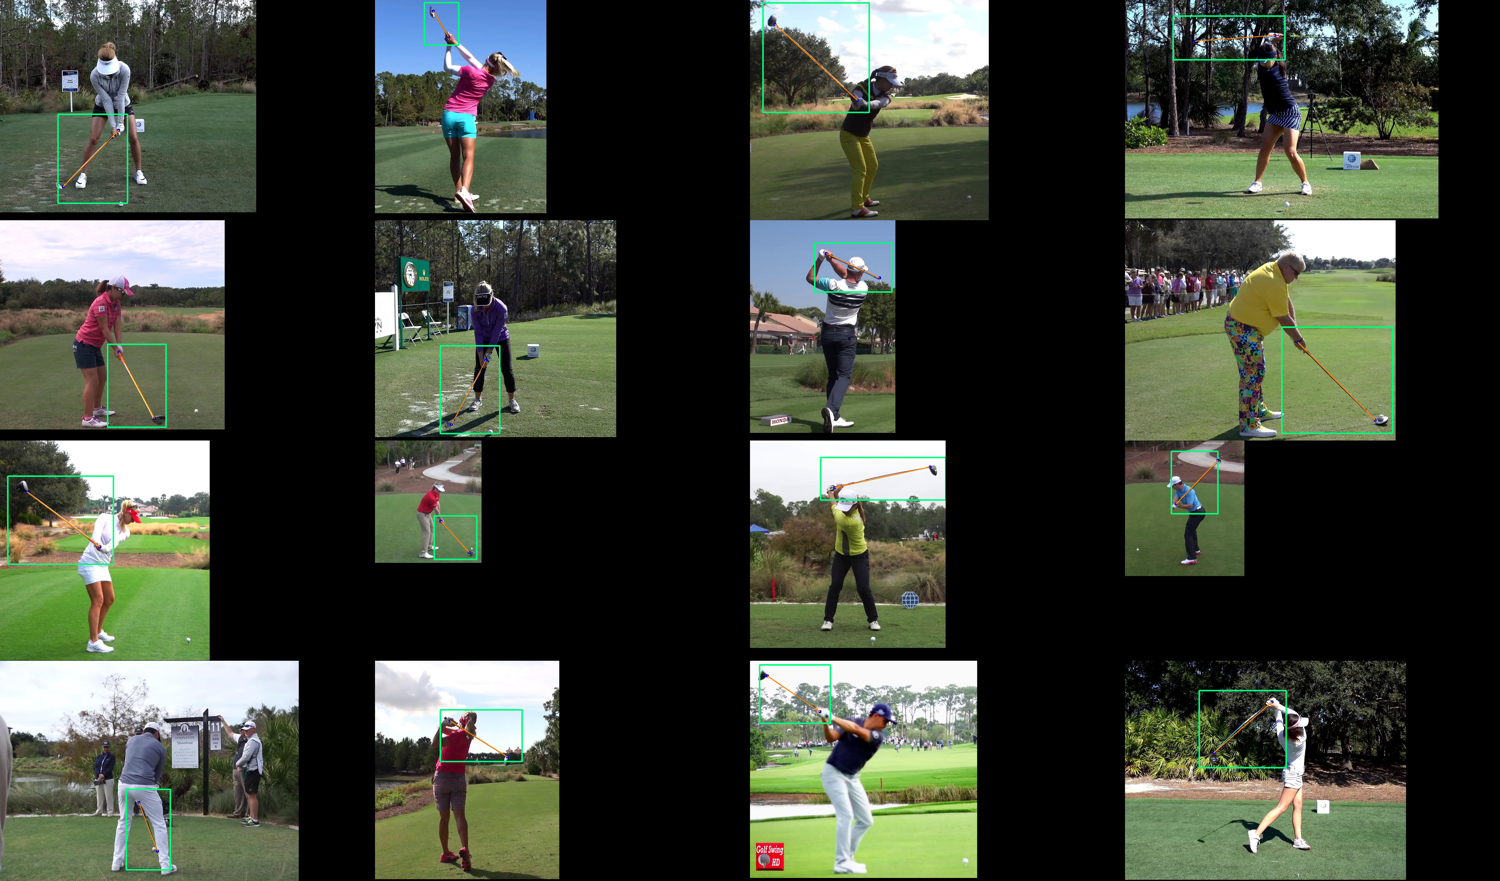

In [65]:
labelled_images = generate_predictions(model, train_dataloader)
display_img = Image.fromarray((torchvision.utils.make_grid(torch.stack(labelled_images, dim=0), padding=0, nrow = 4, normalize=False).permute(1,2,0).numpy()*255).astype(np.uint8))
display(ImageOps.contain(display_img, (1500, 1500)))

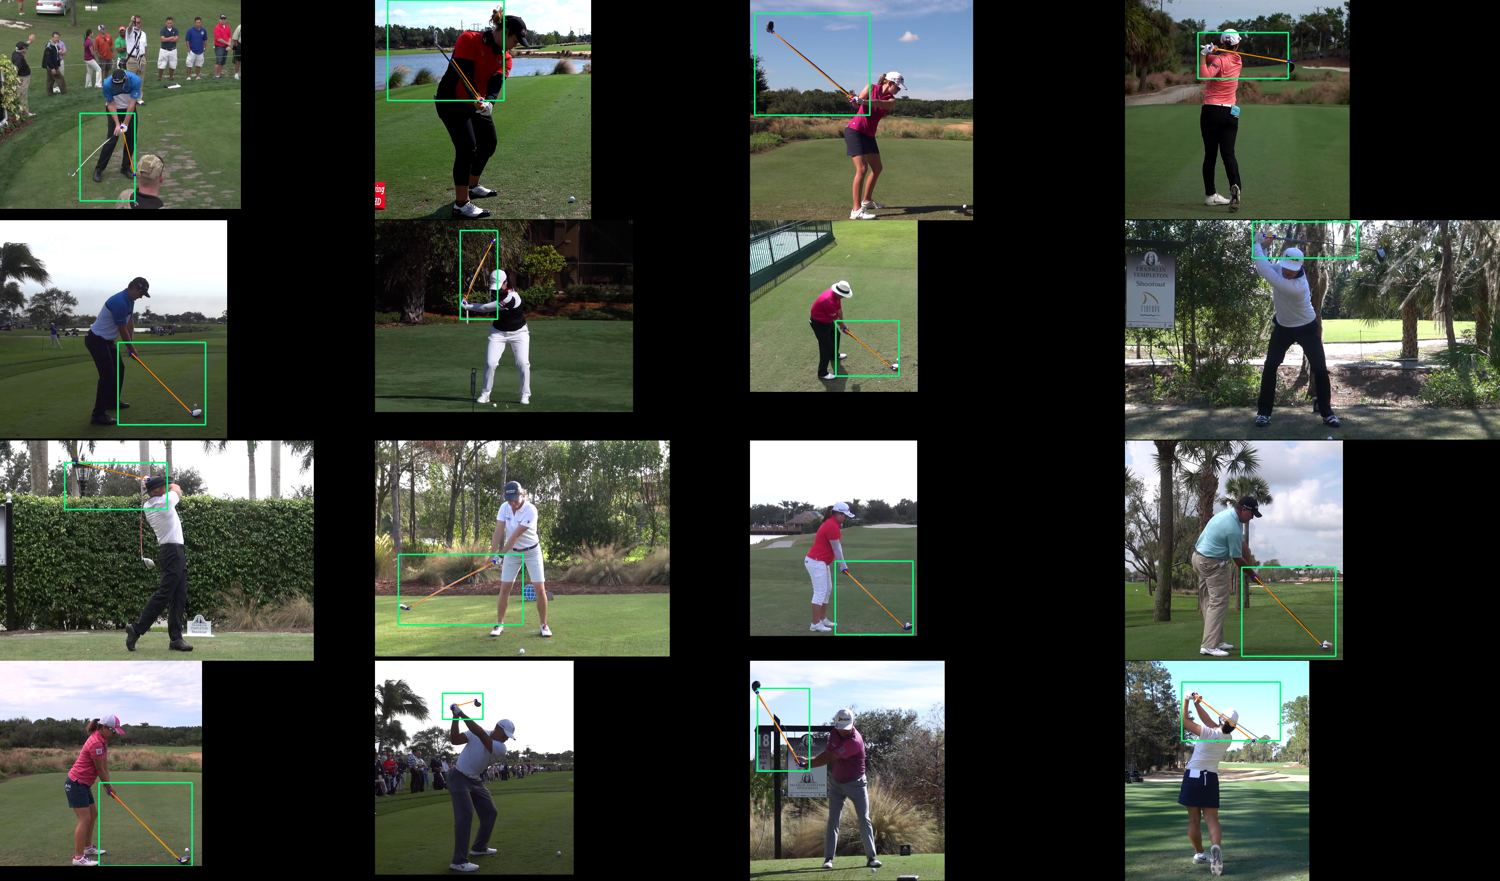

In [66]:
labelled_images = generate_predictions(model, test_dataloader)
display_img = Image.fromarray((torchvision.utils.make_grid(torch.stack(labelled_images, dim=0), padding=0, nrow = 4, normalize=False).permute(1,2,0).numpy()*255).astype(np.uint8))
display(ImageOps.contain(display_img, (1500, 1500)))